# A Generátor látens terében való keresés

Látens térben való keresés gradiens módszerrel

hibafüggvény: az L2 távolság minimalizálása

Jelölje $X$ a keresendő képet, $G$ a generátort, $\vec{z}$ pedig a látens vektort.

A cél egy olyan $\vec{z} \in \mathbb{R}^{100}$ látens vektor keresése, amellyel a lenti távolság minimalizálható.

$$ \min\left(\sum_{i=1}^{n\times m}\sqrt{(X_i-G(\vec{z})_i)^2}\right)$$

A képeket tehát pixelszinten hasonlítjuk össze kiindulásképp. Egyéb metrikákat is alkalmazhatunk a képek hasonlóságának mérésére, ilyen a PCA, a HOG, MSE, stb...

A keresés gradiens-módszerrel történik.

```python
noise = tf.Variable(random_noise, name='noise')
step_size = 0.1
steps = 50
for i in range(steps + 1):
    with tf.GradientTape() as g_tape:
        g_tape.watch(noise)

        generated_image = generator(noise, training=False)[0][0]
        loss = tf.norm(starter_image - generated_image)

    gradients = g_tape.gradient(loss, noise)
    noise = noise - (step_size * gradients)
```
Az algoritmus tehát:
Legyen $l$ a lépésméret, $X \in \mathbb{R}^{n\times m \times 3}$ a keresendő kép, $G$ pedig a betanított generátor.

1. Generáljunk egy képet az aktuális $\vec{z}$ zajvektorral
$$\hat X = G(\vec{z})$$
2. Számoljuk ki a generált kép és a keresendő kép távolságát.
$$ loss = \sum_{i=1}^{n\times m}\sqrt{(X_i-\hat X_i)^2} $$
3. Számoljuk ki a gradienseket a fenti függvény szerint
$$ \vec{grad} = \frac{d}{d\vec{z}} \left[loss\right]$$
4. Módosítsuk a $\vec{z}$ zajvektor elemeit a kapott gradiensek szerint
$$ z_i = z_i - (l \cdot grad_i)$$
5. Ismételjük meg az algoritmust a konvergálásig...

Ezen megközelítés az úgynevezett Gradient Descent, vagyis meghatározott $l$ távolságokkal lépkedve optimalizál az módszer.


Momentummal való kiegészítés:

Jelöljük $t$-vel az időpillanatot.

$$ z_i^t = z_i^{t-1} - (l \cdot f'(z_i^{t-1})$$

$$ valtozas^t = l \cdot f'(z_i^{t-1}) $$

$$ z_i^t = z_i^{t-1} - valtozas^t $$


Momentum esetén a változás:
$$ valtozas^t = l \cdot f'(z_i^{t-1}) + momentum \cdot valtozas^{t-1}$$


momentum 0 - 1 között (0 esetén sima gradient descent)

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

2022-04-27 09:23:57.203353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 09:23:57.203388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
generator = keras.models.load_model('datas/weights/msggan/afhq/msgGenerator.h5')

2022-04-27 09:24:10.962663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 09:24:10.962699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 09:24:10.962724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-04-27 09:24:10.962975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def denormalize_image(image):
    return (image.numpy() * 127.5 + 127.5).astype("uint32")

In [5]:
latent_dim = 100

## A generátor által generált kép visszakeresése

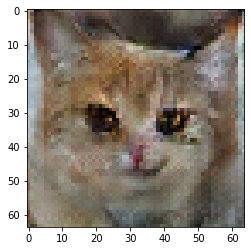

In [36]:
# Generate a random point, and an image from it
# this will be the goal image
tf.random.set_seed(2021)
starter_image_noise = tf.random.normal([1, latent_dim])
starter_image = generator(starter_image_noise, training=False)[0][0]
plt.imshow(denormalize_image(starter_image))

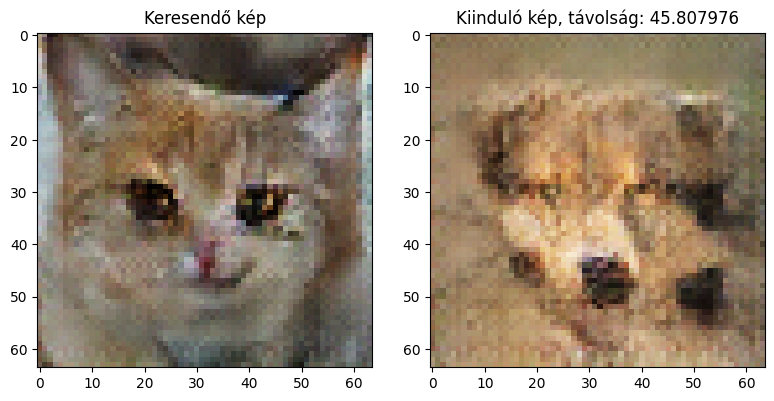

In [37]:
# generate a random starting point
random_noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

# generating an image from the random point
# and calculating the distance between the goal and the random image
random_image = generator(random_noise ,training=False)[0][0]

distance = tf.norm(starter_image-random_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(starter_image), interpolation='none')

axes[1].set_title("Kiinduló kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(random_image), interpolation='none')

In [38]:
# Gradient Descent

def gradient_descent(goal_image, starting_noise, step_size, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    losses = []
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        noise = noise - (step_size * gradients)

        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    loss = tf.norm(goal_image - generated_image)
    losses.append(loss)
    return noise, losses

In [39]:
# Gradient Descent with Momentum

def gradient_descent_momentum(goal_image, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')

    change = 0
    losses = []
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0][0]
            loss = tf.norm(goal_image - generated_image)

        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change
        
        if(verbose):
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow(denormalize_image(generated_image))
            plt.show()

        losses.append(loss)
    generated_image = generator(noise, training=False)[0][0]
    loss = tf.norm(goal_image - generated_image)
    losses.append(loss)
    return noise, losses

Step: 0, Loss: 45.80797576904297


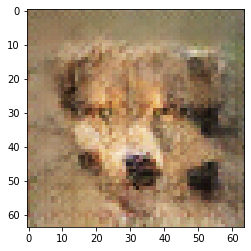

Step: 1, Loss: 40.34307098388672


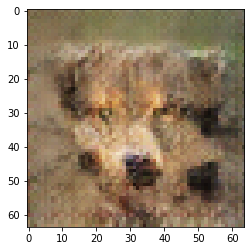

Step: 2, Loss: 37.72770690917969


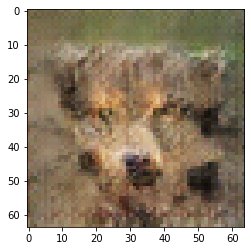

Step: 3, Loss: 35.631351470947266


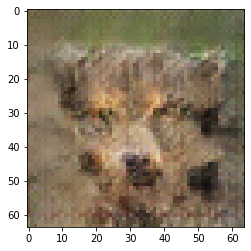

Step: 4, Loss: 33.748512268066406


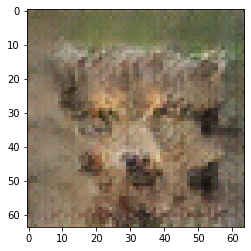

Step: 5, Loss: 31.614248275756836


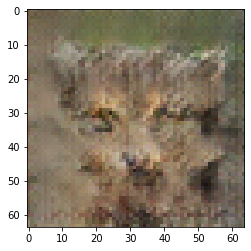

Step: 6, Loss: 30.043621063232422


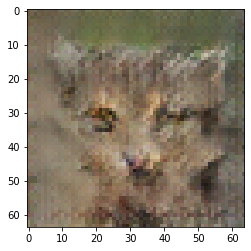

Step: 7, Loss: 28.592609405517578


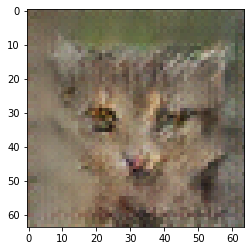

Step: 8, Loss: 27.59170150756836


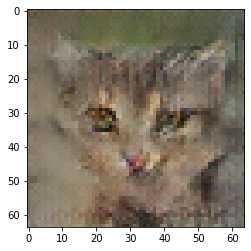

Step: 9, Loss: 26.79111099243164


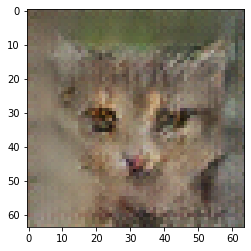

Step: 10, Loss: 26.244365692138672


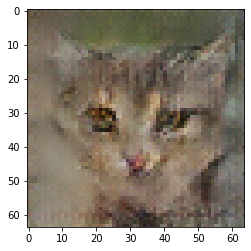

Step: 11, Loss: 26.308191299438477


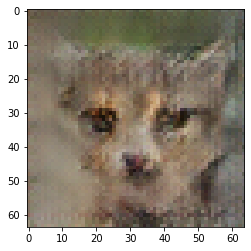

Step: 12, Loss: 27.502288818359375


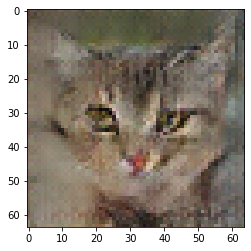

Step: 13, Loss: 26.90699577331543


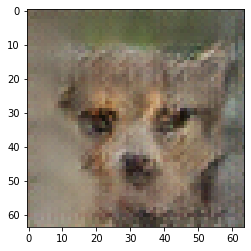

Step: 14, Loss: 26.00870132446289


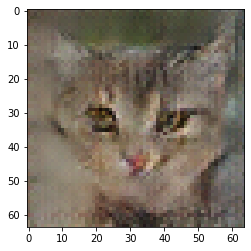

Step: 15, Loss: 26.05589485168457


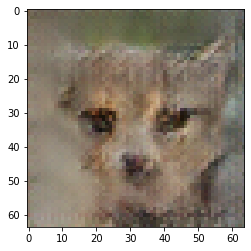

Step: 16, Loss: 26.082304000854492


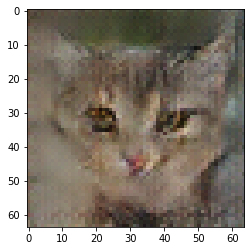

Step: 17, Loss: 26.496063232421875


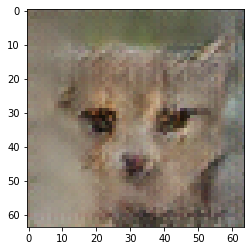

Step: 18, Loss: 26.58123207092285


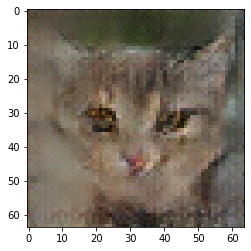

Step: 19, Loss: 26.647523880004883


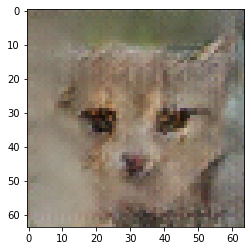

Step: 20, Loss: 26.302398681640625


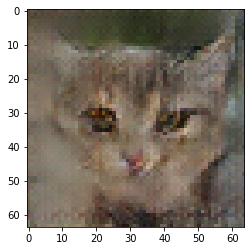

Step: 21, Loss: 26.00088882446289


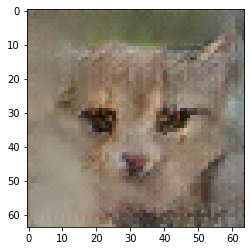

Step: 22, Loss: 25.487497329711914


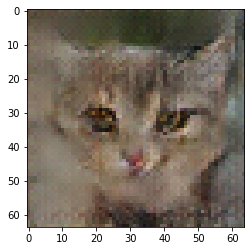

Step: 23, Loss: 25.511259078979492


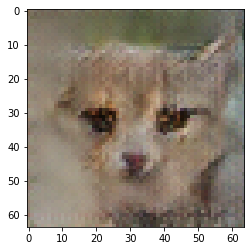

Step: 24, Loss: 25.23858642578125


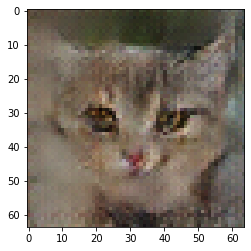

Step: 25, Loss: 25.284109115600586


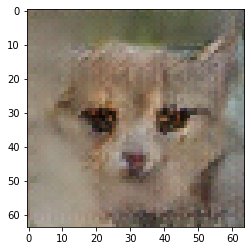

Step: 26, Loss: 25.379579544067383


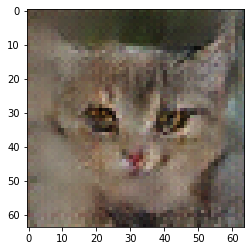

Step: 27, Loss: 25.405057907104492


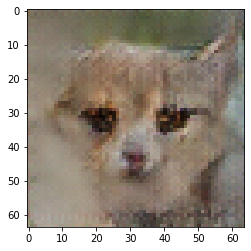

Step: 28, Loss: 25.06977653503418


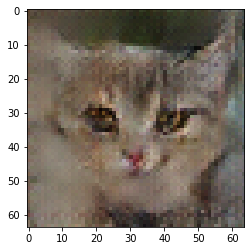

Step: 29, Loss: 24.76412010192871


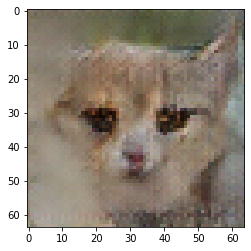

Step: 30, Loss: 25.010648727416992


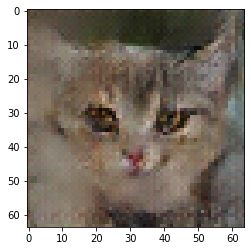

Step: 31, Loss: 24.516817092895508


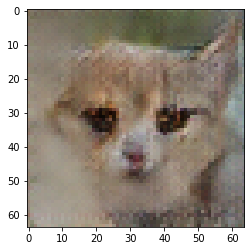

Step: 32, Loss: 24.555994033813477


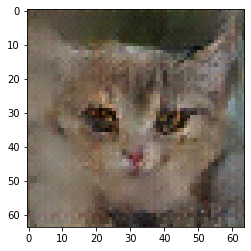

Step: 33, Loss: 23.94314956665039


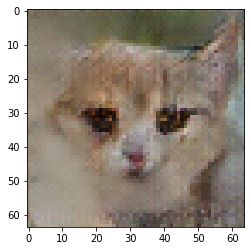

Step: 34, Loss: 24.076642990112305


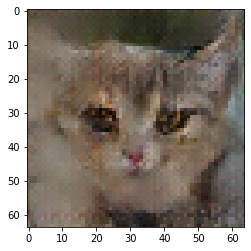

Step: 35, Loss: 23.91848373413086


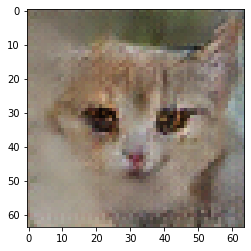

Step: 36, Loss: 23.56480598449707


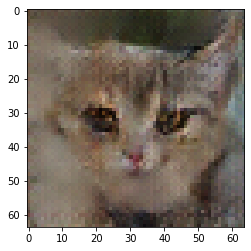

Step: 37, Loss: 23.668777465820312


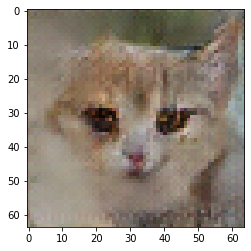

Step: 38, Loss: 23.270183563232422


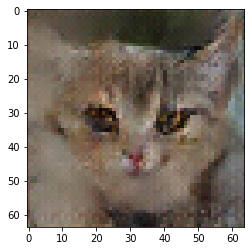

Step: 39, Loss: 23.235692977905273


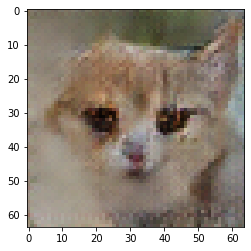

Step: 40, Loss: 22.614826202392578


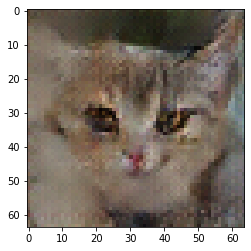

Step: 41, Loss: 22.290390014648438


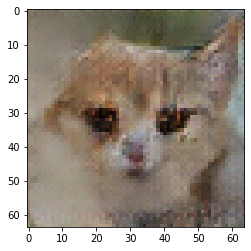

Step: 42, Loss: 22.29487419128418


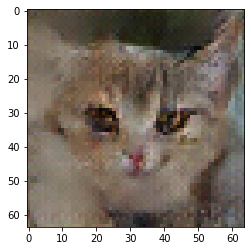

Step: 43, Loss: 21.868757247924805


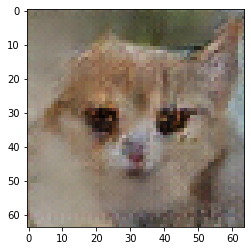

Step: 44, Loss: 21.709489822387695


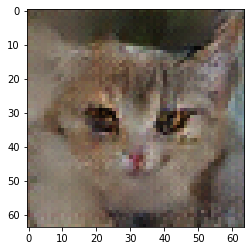

Step: 45, Loss: 21.836551666259766


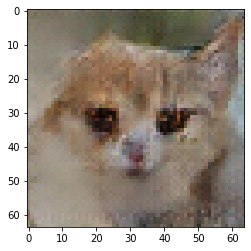

Step: 46, Loss: 22.165996551513672


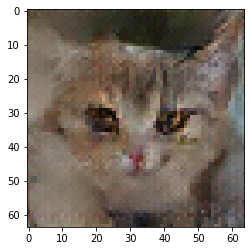

Step: 47, Loss: 21.85402488708496


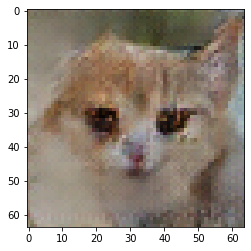

Step: 48, Loss: 21.692718505859375


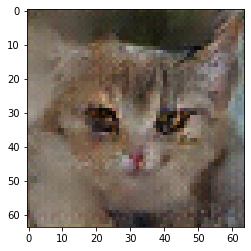

Step: 49, Loss: 21.739463806152344


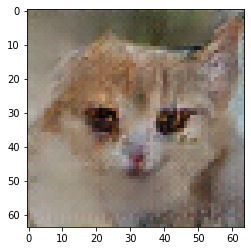

Step: 50, Loss: 21.167503356933594


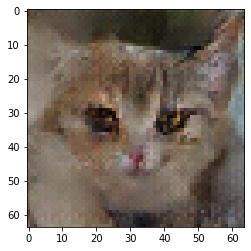

Step: 51, Loss: 21.427202224731445


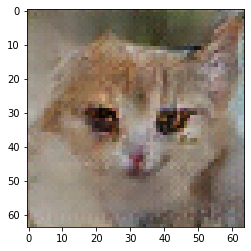

Step: 52, Loss: 21.236068725585938


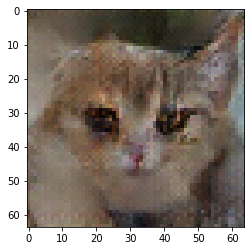

Step: 53, Loss: 21.98102378845215


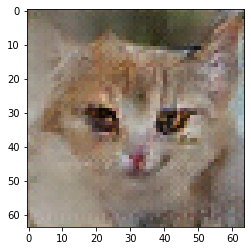

Step: 54, Loss: 20.261531829833984


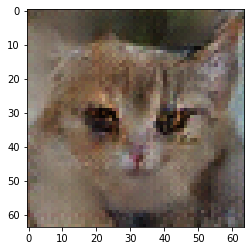

Step: 55, Loss: 20.10643768310547


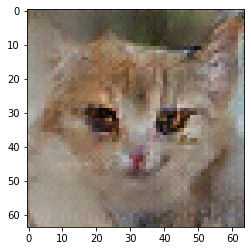

Step: 56, Loss: 19.428205490112305


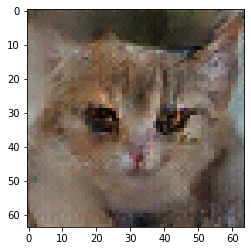

Step: 57, Loss: 19.988515853881836


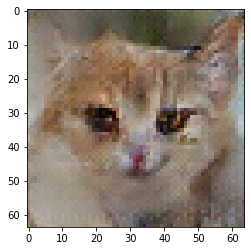

Step: 58, Loss: 20.22222328186035


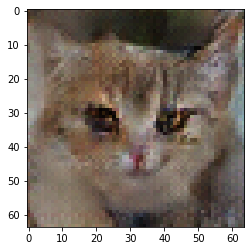

Step: 59, Loss: 19.644718170166016


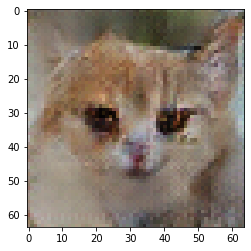

Step: 60, Loss: 19.439313888549805


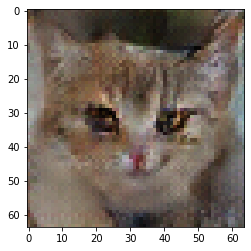

Step: 61, Loss: 19.558259963989258


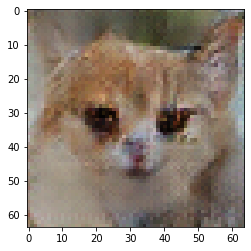

Step: 62, Loss: 19.49127197265625


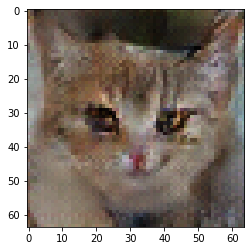

Step: 63, Loss: 18.950115203857422


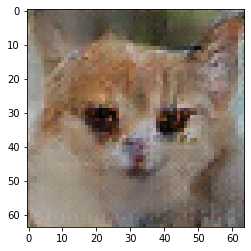

Step: 64, Loss: 18.783199310302734


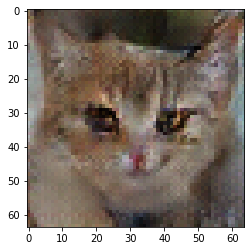

Step: 65, Loss: 19.747621536254883


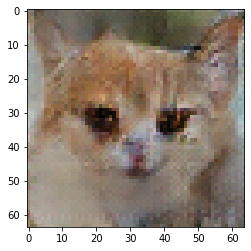

Step: 66, Loss: 18.625246047973633


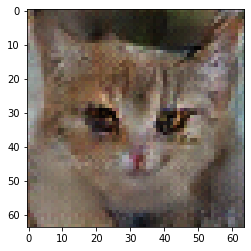

Step: 67, Loss: 18.85679817199707


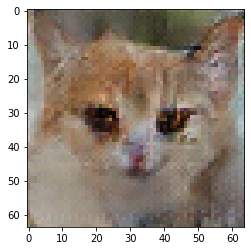

Step: 68, Loss: 18.372310638427734


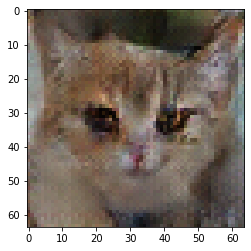

Step: 69, Loss: 18.701963424682617


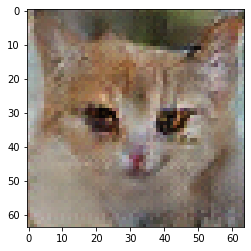

In [40]:
gradient_noise, gd_losses = gradient_descent(starter_image, random_noise, step_size=0.05, steps=70, verbose=True)

Step: 0, Loss: 45.80797576904297


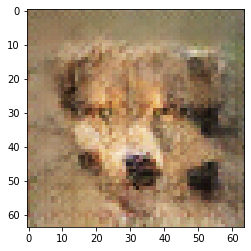

Step: 1, Loss: 42.18914794921875


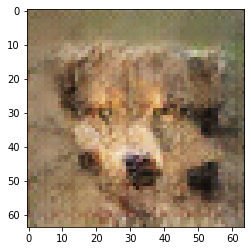

Step: 2, Loss: 38.375003814697266


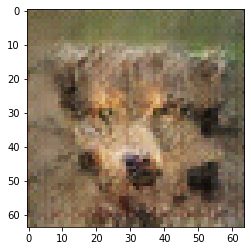

Step: 3, Loss: 36.69226837158203


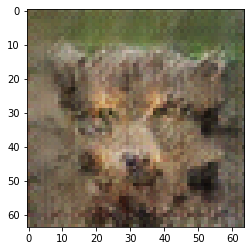

Step: 4, Loss: 33.64955139160156


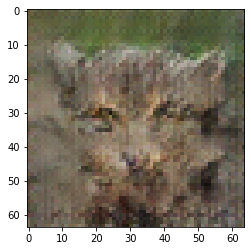

Step: 5, Loss: 29.652353286743164


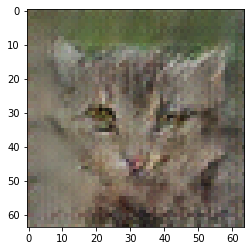

Step: 6, Loss: 28.461198806762695


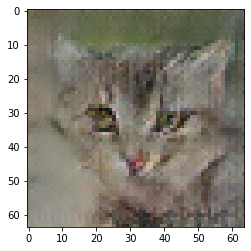

Step: 7, Loss: 29.5756778717041


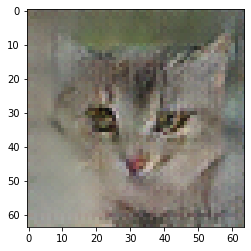

Step: 8, Loss: 28.47071647644043


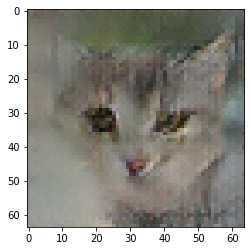

Step: 9, Loss: 27.04027557373047


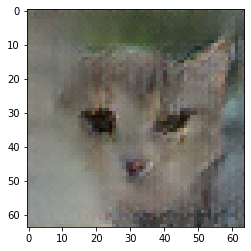

Step: 10, Loss: 27.49372673034668


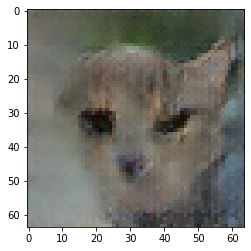

Step: 11, Loss: 27.317028045654297


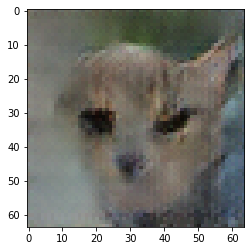

Step: 12, Loss: 26.218046188354492


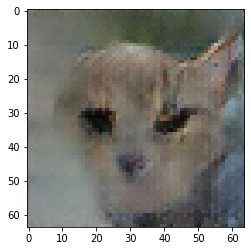

Step: 13, Loss: 25.101985931396484


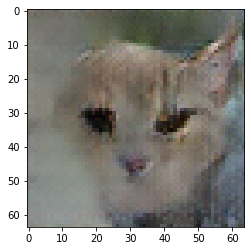

Step: 14, Loss: 24.693145751953125


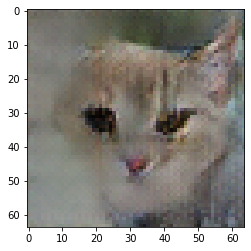

Step: 15, Loss: 24.302082061767578


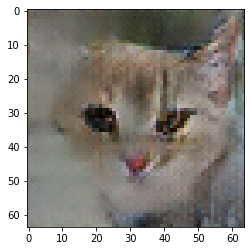

Step: 16, Loss: 23.61679458618164


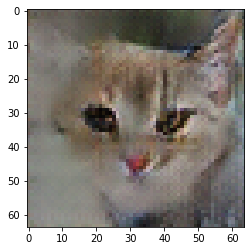

Step: 17, Loss: 22.406991958618164


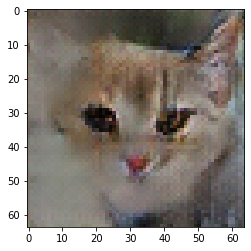

Step: 18, Loss: 21.58880043029785


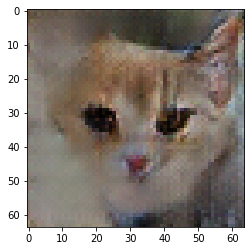

Step: 19, Loss: 21.478164672851562


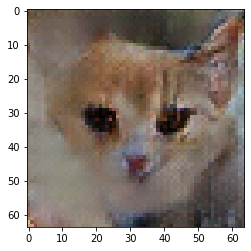

Step: 20, Loss: 20.599180221557617


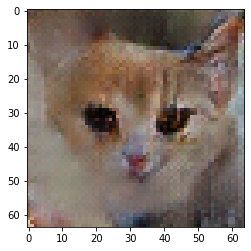

Step: 21, Loss: 19.831205368041992


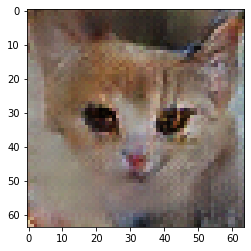

Step: 22, Loss: 18.443138122558594


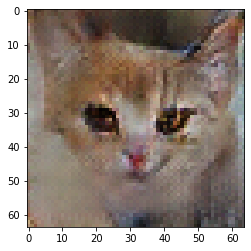

Step: 23, Loss: 17.15577507019043


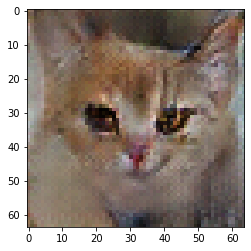

Step: 24, Loss: 16.900615692138672


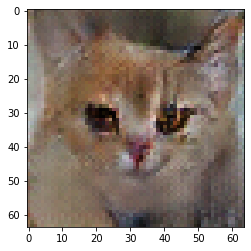

Step: 25, Loss: 16.11528205871582


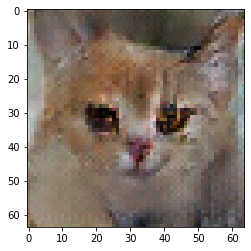

Step: 26, Loss: 15.628058433532715


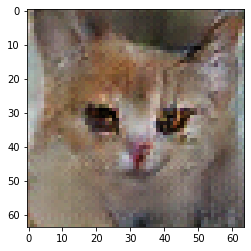

Step: 27, Loss: 15.139345169067383


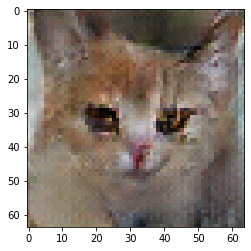

Step: 28, Loss: 14.632129669189453


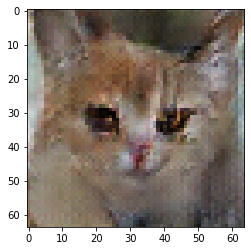

Step: 29, Loss: 14.663273811340332


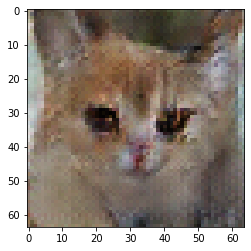

Step: 30, Loss: 14.651235580444336


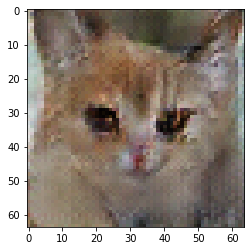

Step: 31, Loss: 14.113248825073242


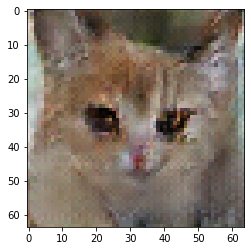

Step: 32, Loss: 13.976702690124512


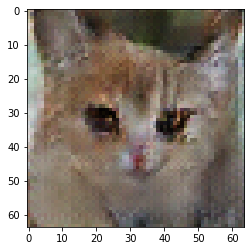

Step: 33, Loss: 13.795944213867188


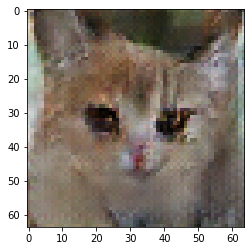

Step: 34, Loss: 13.27260971069336


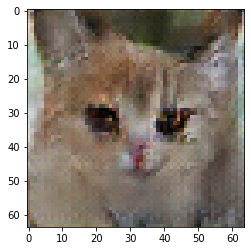

Step: 35, Loss: 13.137555122375488


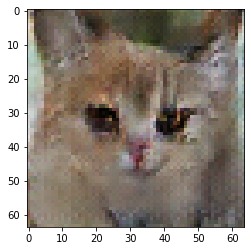

Step: 36, Loss: 12.879838943481445


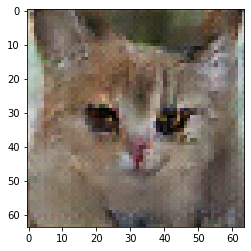

Step: 37, Loss: 12.385839462280273


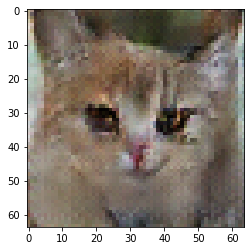

Step: 38, Loss: 12.10525131225586


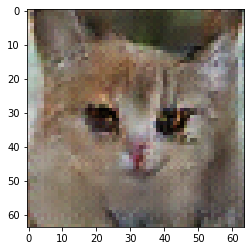

Step: 39, Loss: 11.554917335510254


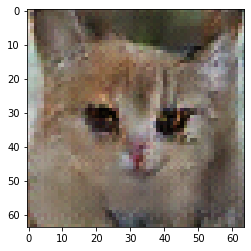

Step: 40, Loss: 11.1614351272583


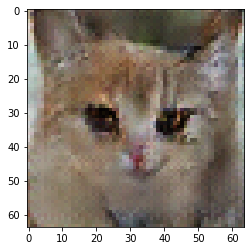

Step: 41, Loss: 10.636561393737793


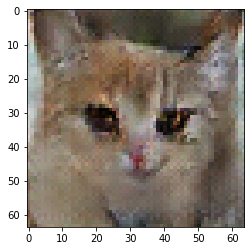

Step: 42, Loss: 10.582058906555176


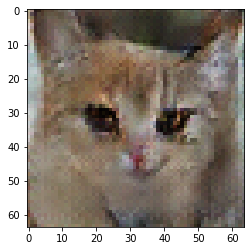

Step: 43, Loss: 10.156400680541992


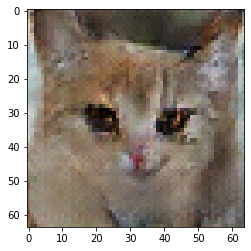

Step: 44, Loss: 9.871208190917969


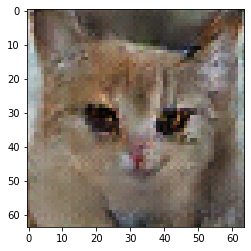

Step: 45, Loss: 9.226997375488281


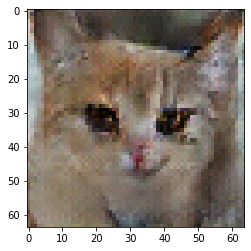

Step: 46, Loss: 9.314770698547363


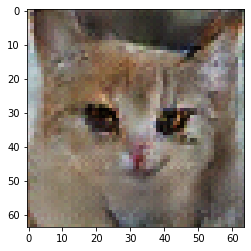

Step: 47, Loss: 9.498123168945312


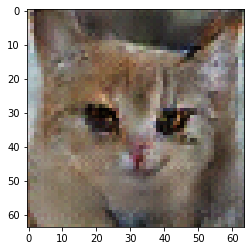

Step: 48, Loss: 9.920854568481445


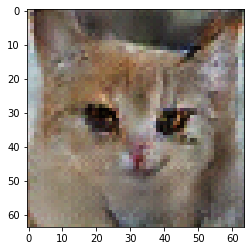

Step: 49, Loss: 10.297971725463867


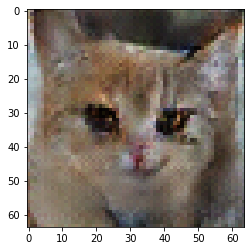

Step: 50, Loss: 9.632108688354492


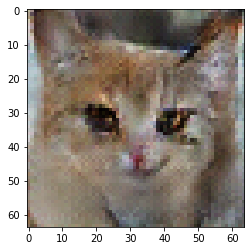

Step: 51, Loss: 9.399870872497559


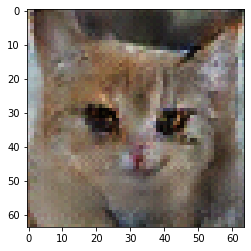

Step: 52, Loss: 9.843626976013184


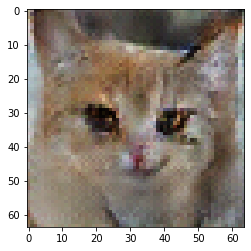

Step: 53, Loss: 9.763033866882324


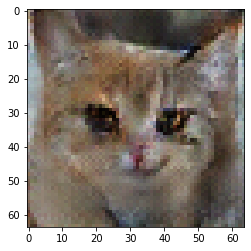

Step: 54, Loss: 10.865438461303711


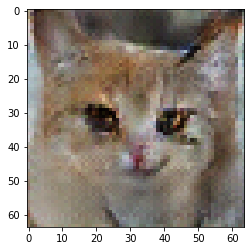

Step: 55, Loss: 11.340066909790039


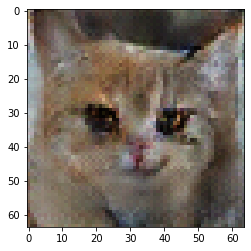

Step: 56, Loss: 9.562170028686523


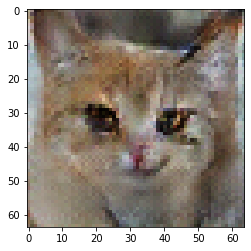

Step: 57, Loss: 8.523371696472168


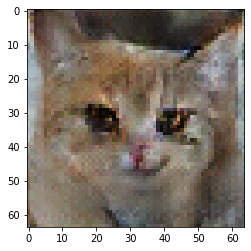

Step: 58, Loss: 8.718960762023926


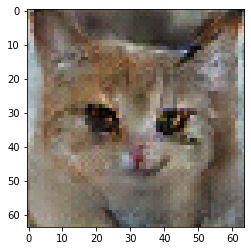

Step: 59, Loss: 9.676344871520996


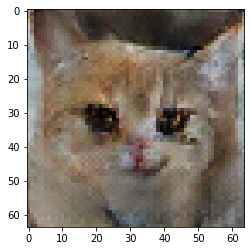

Step: 60, Loss: 7.512368202209473


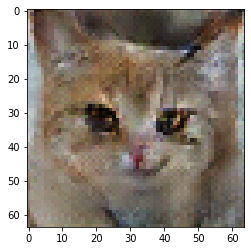

Step: 61, Loss: 7.540887832641602


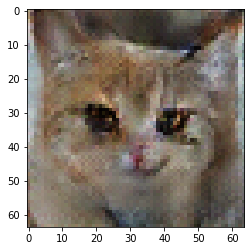

Step: 62, Loss: 12.591809272766113


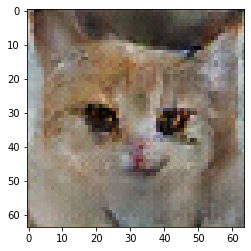

Step: 63, Loss: 10.710771560668945


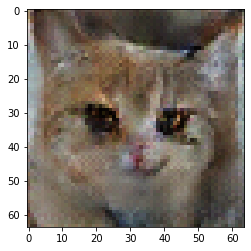

Step: 64, Loss: 9.052553176879883


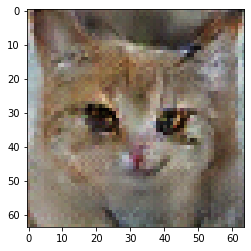

Step: 65, Loss: 9.452564239501953


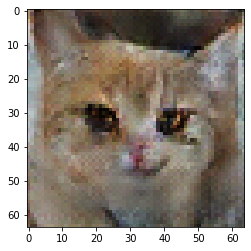

Step: 66, Loss: 6.593413829803467


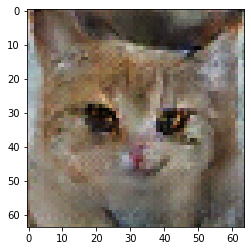

Step: 67, Loss: 10.319181442260742


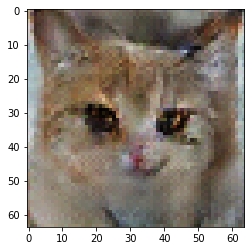

Step: 68, Loss: 14.759498596191406


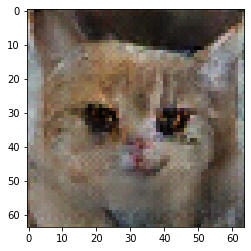

Step: 69, Loss: 13.794951438903809


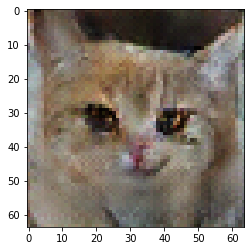

In [41]:
gradient_momentum_noise, gdm_losses =\
    gradient_descent_momentum(starter_image, random_noise, step_size=0.03, momentum=0.9, steps=70, verbose=True)

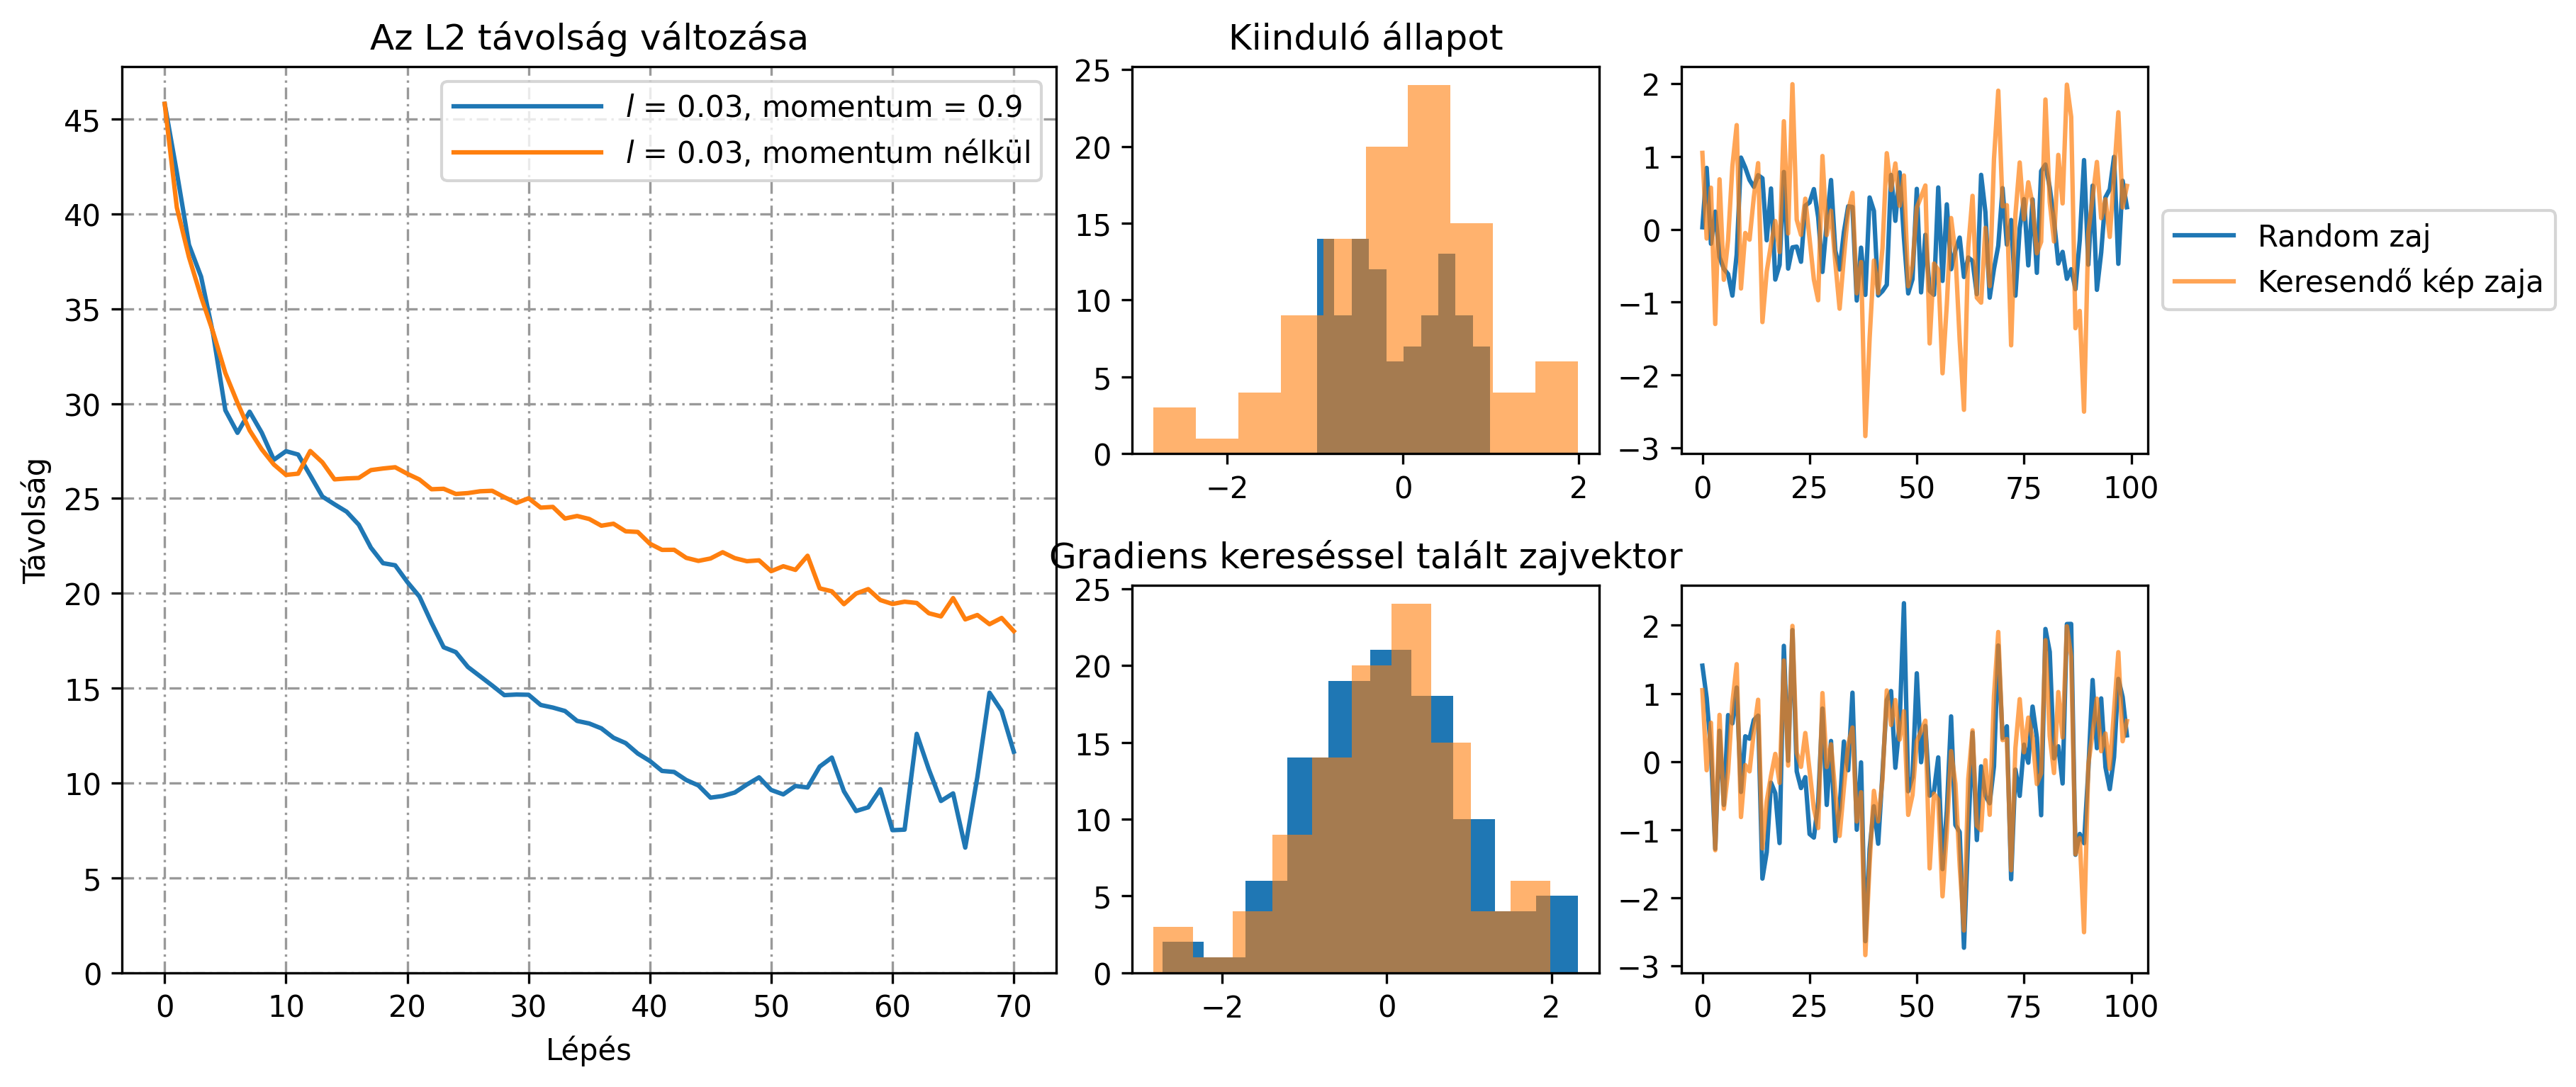

In [42]:
fig = plt.figure(figsize=(12, 5), dpi=300, constrained_layout=True)
axs = fig.subplot_mosaic([['Losses', 'TopRight', 'TopRight2'],['Losses', 'BottomRight', 'BottomRight2']],
                          gridspec_kw={'width_ratios':[2, 1, 1]})
axs['Losses'].set_xlabel('Lépés')
axs['Losses'].set_ylabel('Távolság')
axs['Losses'].set_title('Az L2 távolság változása')

axs['Losses'].grid(True, color='0.6', dashes=(5, 2, 1, 2))

axs['Losses'].plot(gdm_losses, label="$l$ = 0.03, momentum = 0.9")
axs['Losses'].plot(gd_losses, label="$l$ = 0.03, momentum nélkül")
axs['Losses'].set_ylim(bottom=0)
axs['Losses'].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs['Losses'].xaxis.set_major_locator(ticker.MultipleLocator(10))
axs['Losses'].legend(loc=0, handlelength=5)

axs['TopRight'].set_title("Kiinduló állapot")
axs['TopRight'].hist(random_noise.numpy().flatten())
axs['TopRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6)

axs['TopRight2'].plot(random_noise.numpy().flatten(), label="Random zaj")
axs['TopRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7, label="Keresendő kép zaja")
axs['TopRight2'].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs['BottomRight'].set_title("Gradiens kereséssel talált zajvektor")
axs['BottomRight'].hist(gradient_momentum_noise.numpy().flatten())
axs['BottomRight'].hist(starter_image_noise.numpy().flatten(), alpha=0.6)

axs['BottomRight2'].plot(gradient_momentum_noise.numpy().flatten())
axs['BottomRight2'].plot(starter_image_noise.numpy().flatten(), alpha=0.7)
plt.show()

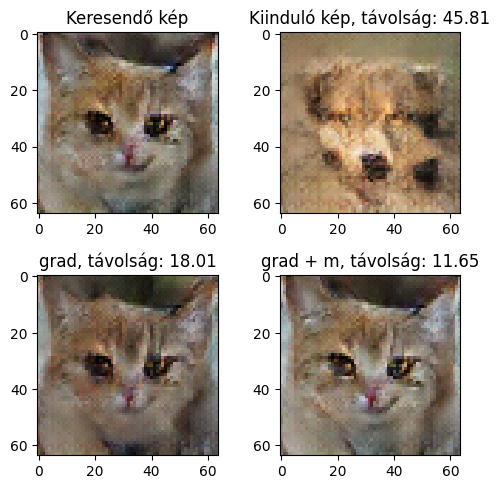

In [43]:
grad_image = generator(gradient_noise, training=False)[0][0]

grad_momentum_image = generator(gradient_momentum_noise, training=False)[0][0]

distance_grad = tf.norm(starter_image - grad_image)
distance_grad_momentum = tf.norm(starter_image - grad_momentum_image)

fig, axes = plt.subplots(figsize=(5, 5), nrows=2, ncols=2, dpi=100)
plt.tight_layout()
axes[0, 0].set_title("Keresendő kép")
axes[0, 0].imshow(denormalize_image(starter_image), interpolation='none')

axes[0, 1].set_title("Kiinduló kép" + ", távolság: " + '{0:.2f}'.format(distance.numpy()))
axes[0, 1].imshow(denormalize_image(random_image), interpolation='none')

axes[1, 0].set_title("grad" + ", távolság: " + '{0:.2f}'.format(distance_grad.numpy()))
axes[1, 0].imshow(denormalize_image(grad_image), interpolation='none')

axes[1, 1].set_title("grad + m" + ", távolság: " + '{0:.2f}'.format(distance_grad_momentum.numpy()))
axes[1, 1].imshow(denormalize_image(grad_momentum_image), interpolation='none')

## Validációs halmazban szereplő kép legközeli generált képének megtatálása

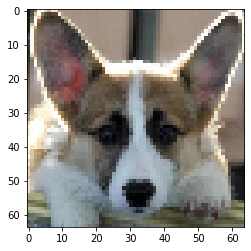

In [20]:
validating_image = plt.imread("./datas/afhq/val/dog/flickr_dog_000212.jpg")

# Resize it to 64x64
resized = tf.image.resize(validating_image, [64, 64])

resized = (resized - 127.5) / 127.5  # Normalize image

plt.imshow(denormalize_image(resized))

Step: 0, Loss: 55.58946990966797


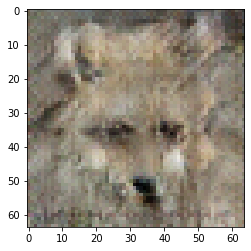

Step: 1, Loss: 54.52047348022461


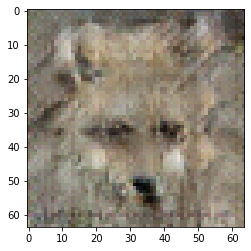

Step: 2, Loss: 52.67994689941406


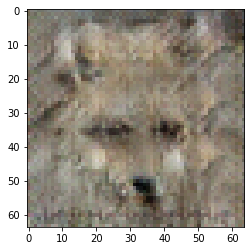

Step: 3, Loss: 50.744972229003906


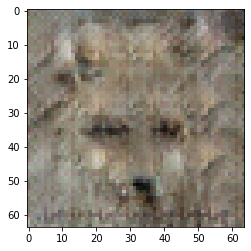

Step: 4, Loss: 49.18118667602539


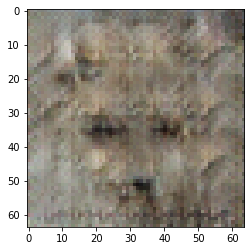

Step: 5, Loss: 48.16749954223633


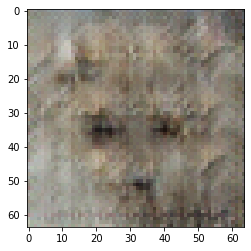

Step: 6, Loss: 47.970619201660156


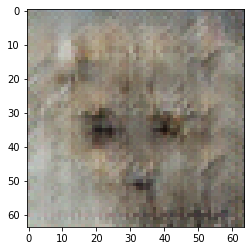

Step: 7, Loss: 47.85302734375


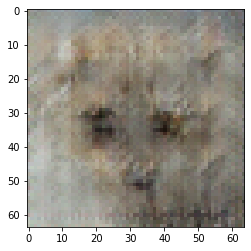

Step: 8, Loss: 47.152584075927734


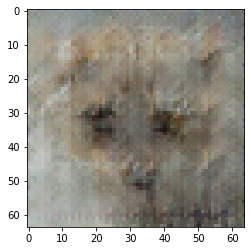

Step: 9, Loss: 46.29869842529297


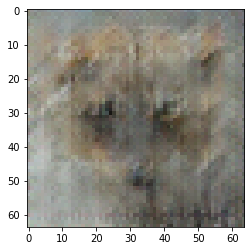

Step: 10, Loss: 45.984256744384766


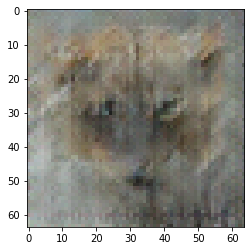

Step: 11, Loss: 45.562721252441406


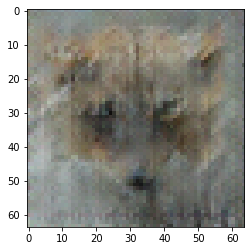

Step: 12, Loss: 44.755123138427734


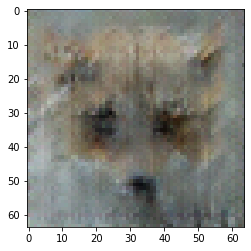

Step: 13, Loss: 44.252586364746094


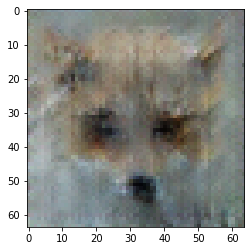

Step: 14, Loss: 44.14122772216797


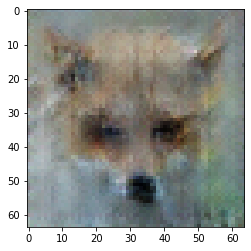

Step: 15, Loss: 44.27880096435547


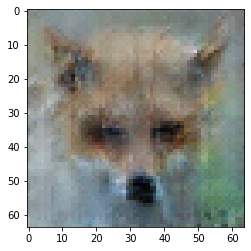

Step: 16, Loss: 44.03409194946289


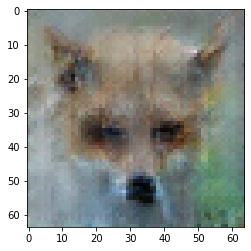

Step: 17, Loss: 43.510955810546875


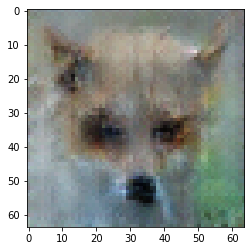

Step: 18, Loss: 43.062217712402344


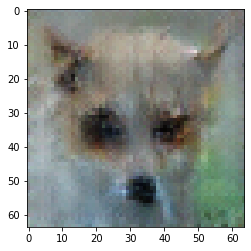

Step: 19, Loss: 42.80146026611328


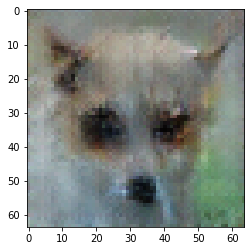

Step: 20, Loss: 42.581077575683594


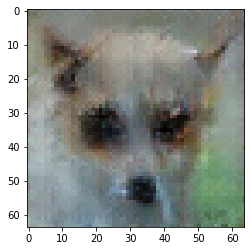

Step: 21, Loss: 42.3813591003418


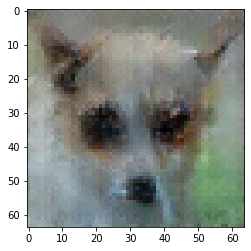

Step: 22, Loss: 42.23195266723633


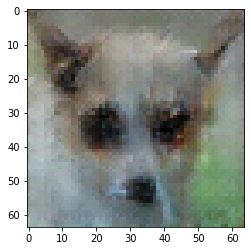

Step: 23, Loss: 42.02931594848633


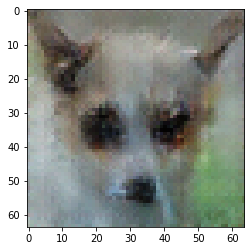

Step: 24, Loss: 41.756134033203125


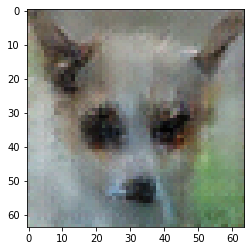

Step: 25, Loss: 41.46292495727539


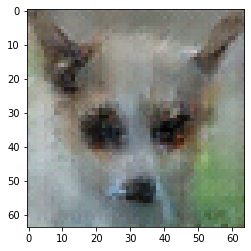

Step: 26, Loss: 41.2155876159668


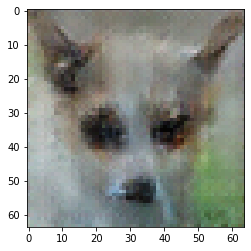

Step: 27, Loss: 40.988136291503906


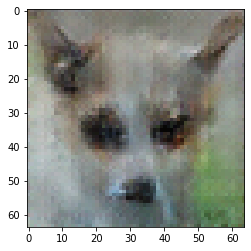

Step: 28, Loss: 40.7664680480957


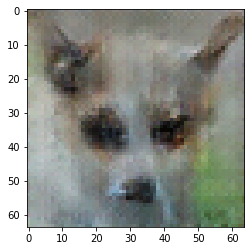

Step: 29, Loss: 40.60324478149414


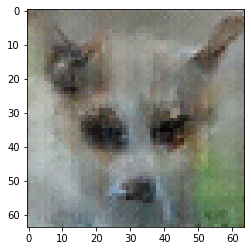

Step: 30, Loss: 40.43030548095703


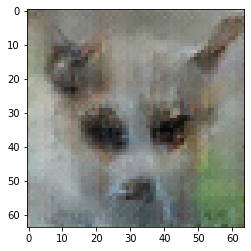

Step: 31, Loss: 40.3104248046875


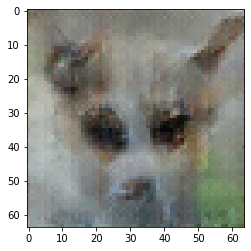

Step: 32, Loss: 40.18218994140625


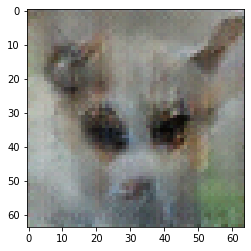

Step: 33, Loss: 40.013023376464844


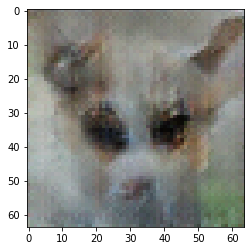

Step: 34, Loss: 39.789634704589844


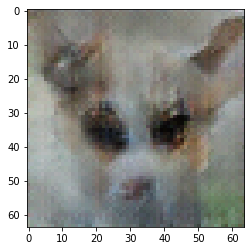

Step: 35, Loss: 39.5793571472168


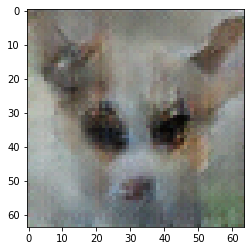

Step: 36, Loss: 39.3718376159668


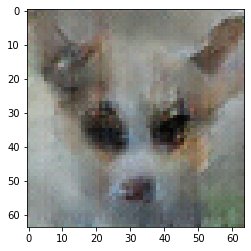

Step: 37, Loss: 39.20556640625


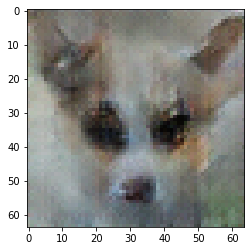

Step: 38, Loss: 39.054988861083984


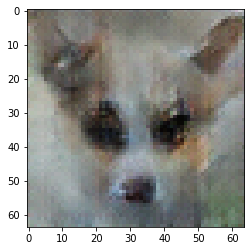

Step: 39, Loss: 38.9168586730957


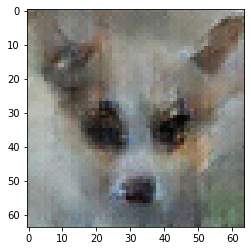

Step: 40, Loss: 38.73065948486328


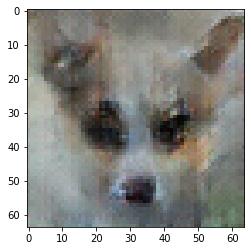

Step: 41, Loss: 38.57600021362305


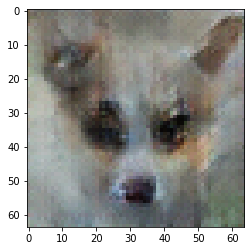

Step: 42, Loss: 38.41257858276367


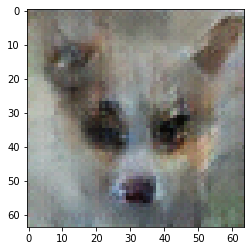

Step: 43, Loss: 38.271453857421875


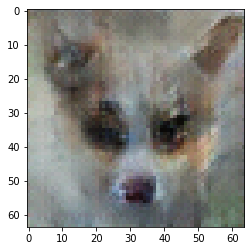

Step: 44, Loss: 38.18486404418945


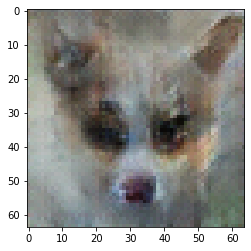

Step: 45, Loss: 38.11946105957031


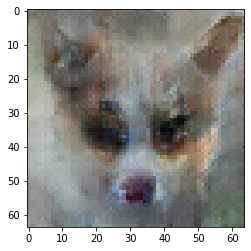

Step: 46, Loss: 38.00923538208008


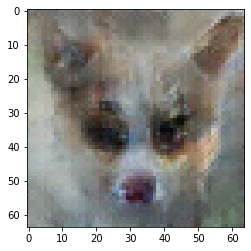

Step: 47, Loss: 37.86906051635742


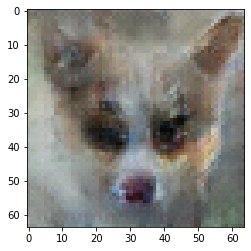

Step: 48, Loss: 37.75120544433594


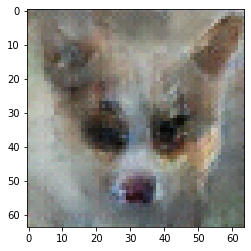

Step: 49, Loss: 37.65610885620117


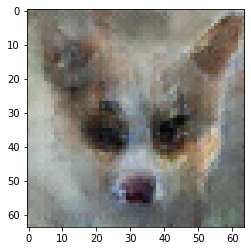

Step: 50, Loss: 37.612125396728516


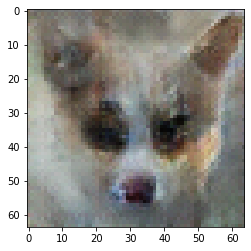

Step: 51, Loss: 37.555870056152344


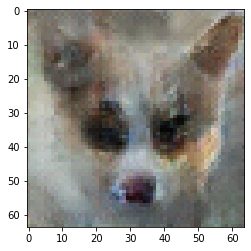

Step: 52, Loss: 37.44987106323242


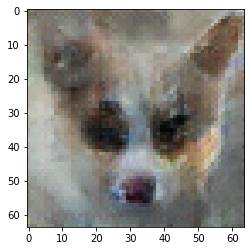

Step: 53, Loss: 37.34552764892578


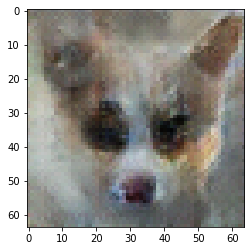

Step: 54, Loss: 37.260459899902344


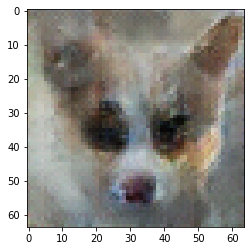

Step: 55, Loss: 37.18031311035156


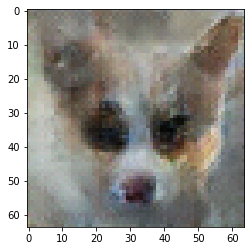

Step: 56, Loss: 37.08568572998047


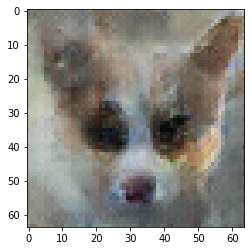

Step: 57, Loss: 37.00353240966797


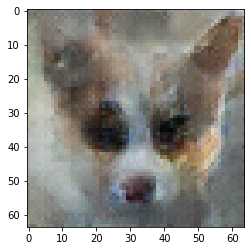

Step: 58, Loss: 36.914512634277344


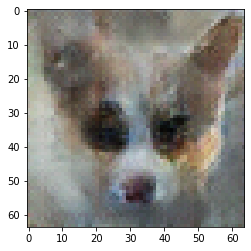

Step: 59, Loss: 36.816383361816406


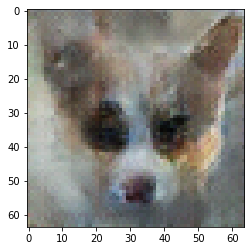

Step: 60, Loss: 36.73977279663086


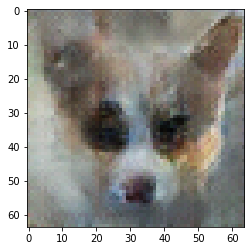

Step: 61, Loss: 36.68265151977539


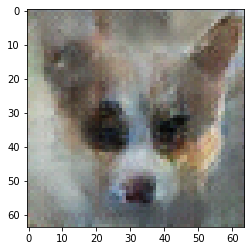

Step: 62, Loss: 36.62101745605469


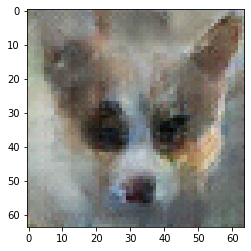

Step: 63, Loss: 36.54560852050781


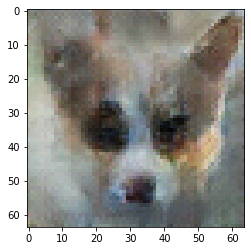

Step: 64, Loss: 36.484764099121094


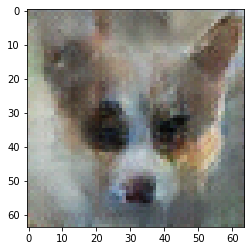

Step: 65, Loss: 36.424076080322266


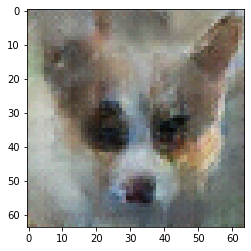

Step: 66, Loss: 36.3586311340332


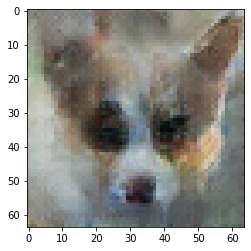

Step: 67, Loss: 36.30742263793945


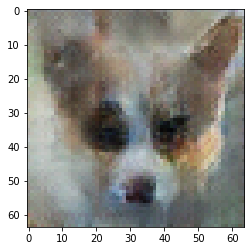

Step: 68, Loss: 36.27714920043945


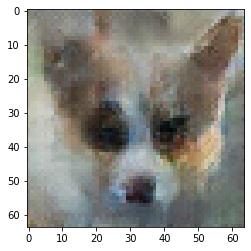

Step: 69, Loss: 36.2418212890625


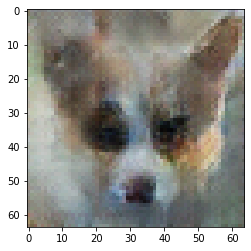

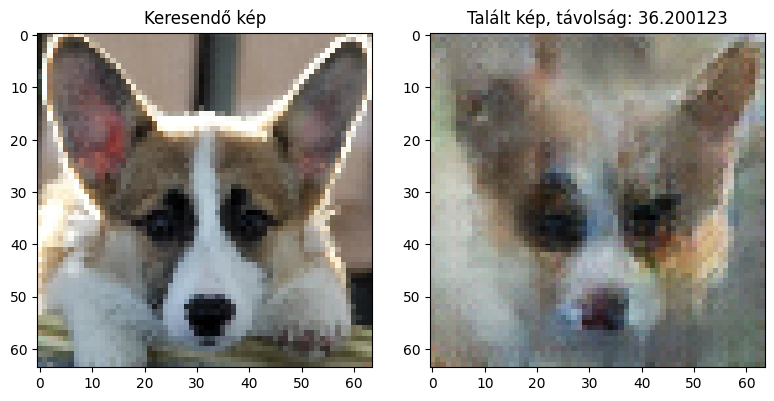

In [21]:
tf.random.set_seed(26)
noise = tf.random.uniform([1, latent_dim], minval=-1, maxval=1)

found_noise, _ = gradient_descent_momentum(resized, noise, step_size=0.03, momentum=0.9, steps=70, verbose=True)

found_image = generator(found_noise, training=False)[0][0]

distance = tf.norm(resized - found_image)

fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, dpi=100)
plt.tight_layout()
axes[0].set_title("Keresendő kép")
axes[0].imshow(denormalize_image(resized), interpolation='none')

axes[1].set_title("Talált kép" + ", távolság: " + str(distance.numpy()))
axes[1].imshow(denormalize_image(found_image), interpolation='none')